# Predict goals scored at even strenght using advanced stats(analytics)
Per wikipedia:<br>
In ice hockey, analytics is the analysis of the characteristics of hockey players and teams through the use of statistics and other tools to gain a greater understanding of the effects of their performance. Three commonly used statistics in ice hockey analytics are **Corsi** and **Fenwick**, both of which use shot attempts to approximate puck possession, and **PDO**, which is often considered a measure of luck. <br>


## For season 2017-18. 
Even Strength situations, where a given player has scored at least one goal.<br>
Data was gathered from:
<br>
https://www.hockey-reference.com/play-index/ppbp_finder.cgi?request=1&match=single&year_min=2018&year_max=2018&season_start=1&season_end=-1&rookie=N&age_min=0&age_max=99&pos=S&situation_id=ev&c1stat=goals&c1comp=gt&c1val=1&order_by=games_played
 



<a id="1"></a> <br>
### Data Overview
**Pos** -- Position<br>
**GP** -- Games played<br>
**G &#8209;** - Goals scored<br>
__A__ -- Assists<br>
**PTS** -- Points<br>

 **Corsi** (EV)<br>
> **CF** -- Corsi For at Even Strength: Shots + Blocks + Misses<br>
**CA** -- Corsi Against at Even Strength: Shots + Blocks + Misses <br>
**CF%** -- Corsi For % at Even Strength: CF / (CF + CA)<br> 

**Fenwick (EV)**<br>
> **FF** -- Fenwick For at Even Strength: Shots + Misses  <br>
**FA** -- Fenwick Against at Even Strength: Shots + Misses<br> 
**FF%** -- Fenwick For % at Even Strength: FF / (FF + FA) <br>
**FF% rel** -- Relative Fenwick For % at Even Strength<br>

**PDO (EV)**<br>
>**oiSH%** -- Team On-Ice Shooting Percentage at Even Strength. Shooting % while this player/team was on the ice<br>
**oiSV%** -- Team On-Ice Save Percentage at Even Strength. Save % while this player/team was on the ice<br>
**PDO** -- PDO at Even Strength. Shooting % + Save %<br>

**Zone Starts (EV)**<br>
> **oZS%** -- Offensive Zone Start % at Even Strength<br>
**dZS%** -- Defensive Zone Start % at Even Strength<br>

**TOI/Gm** -- Avg. TOI at Even Strength : Time on Ice per game, in minutes

**Faceoff**
> **FOW** -- Faceoff Wins at Even Strength<br>
**FOL** -- Faceoff Losses at Even Strength<br>
**FO%** -- Faceoff Win Percentage at Even Strength<br> 

**HIT** -- Hits at Even Strength<br>
**BLK** -- Blocks at Even Strength<br>
**TK** -- Takeaways<br>
**GV** -- Giveaways<br>


<a id="2"></a> 
### Importing modules and loading data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import sklearn as sk
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import yellowbrick
from sklearn.linear_model import Ridge
from sklearn.preprocessing import Imputer
from yellowbrick.regressor import ResidualsPlot
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv("../input/2018as.csv" ) 

<a id="3"></a> 
### First look at dataframe 


In [3]:
# shape of dataset, rows and columns
print("rows, columns: "+str(df.shape))
print(len(str(df.shape))*'-')
print(df.dtypes.value_counts())
print(len(str(df.shape))*'-')
df.head(2)

rows, columns: (717, 28)
---------
int64      14
float64    13
object      1
dtype: int64
---------


,Pos,GP,G,A,PTS,CF,CA,CF%,CF% rel,C/60,Crel/60,FF,FA,FF%,FF% rel,oiSH%,oiSV%,PDO,oZS%,dZS%,TOI/Gm,FOW,FOL,FO%,HIT,BLK,TK,GV
0,RW,82,21,16,37,1135,957,54.3,2.2,10.3,5.2,784,716,52.3,1.6,10.1,91.0,101.1,58.9,41.1,12.6,22,30,42.3,37,24,30,21
1,LW,82,9,10,19,847,832,50.4,-3.7,1.0,-8.4,641,607,51.4,-2.5,5.9,91.2,97.1,35.4,64.6,11.3,45,52,46.4,129,44,22,21


In [4]:
# check for null values  
for column in df:
    if df[column].isnull().any():
       print('{0} has {1} null values'.format(column, df[column].isnull().sum()))

FO% has 220 null values


**Meaning that not all players take faceoffs during a season.**

In [5]:
# Removing all Faceoff related stats from the dataframe
df.drop(['FO%','FOW','FOL'], axis=1, inplace=True)
# check again for null values
df.isnull().values.any()

False

In [6]:
## Descriptive statistics of dataset
df.describe(include='all').transpose()
 

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Pos,717,4,C,253,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GP,717,NaN,NaN,NaN,60.6025,22.6704,1,47,69,79,82
G,717,NaN,NaN,NaN,7.87029,6.53492,1,3,6,11,35
A,717,NaN,NaN,NaN,12.5704,9.0963,0,6,11,18,49
PTS,717,NaN,NaN,NaN,20.4407,14.401,1,9,18,29,84
CF,717,NaN,NaN,NaN,826.877,420.806,6,507,858,1158,1898
CA,717,NaN,NaN,NaN,820.9,392.371,10,540,866,1110,1862
CF%,717,NaN,NaN,NaN,49.5462,4.0628,30.2,47.3,49.8,52.1,63.2
CF% rel,717,NaN,NaN,NaN,-0.339052,4.01532,-23.1,-2.8,-0.1,2.3,10.9
C/60,717,NaN,NaN,NaN,-0.866109,9.23822,-45.9,-6.2,-0.5,4.9,28.2


<a id="4"></a> 
### Feature selection
Discarding all of the compiled faetures. <br>
I suspect that they will be strongly correlated. I will use one of aggregated features instead<br>
For instance: CF% = CF / (CF + CA). -- keeping CF% .


In [7]:
df.drop(['CF', 'CA','CF% rel', 'C/60', 'Crel/60', 'FF', 'FA','FF% rel','oiSH%', 'oiSV%'], axis=1, inplace=True)
df.shape

(717, 15)

Since we are trying to predict Goals, I will also drop Assists and Points as they serve no purpose and are not advanced stats per se

In [8]:
df.drop(['A', 'PTS'], axis=1, inplace=True)
df.shape

(717, 13)

##### Data now look as follow:

In [9]:
df.head()

,Pos,GP,G,CF%,FF%,PDO,oZS%,dZS%,TOI/Gm,HIT,BLK,TK,GV
0,RW,82,21,54.3,52.3,101.1,58.9,41.1,12.6,37,24,30,21
1,LW,82,9,50.4,51.4,97.1,35.4,64.6,11.3,129,44,22,21
2,D,82,10,49.6,49.2,101.6,45.7,54.3,20.0,120,100,50,43
3,D,82,4,52.9,54.5,98.3,47.7,52.3,18.8,112,124,49,37
4,D,82,2,50.0,49.6,100.7,48.8,51.2,16.7,54,94,24,62


#### Not sure how important of a feature *Pos* will be in the end,<br> but I am curious regarding the Goals by postion distribution


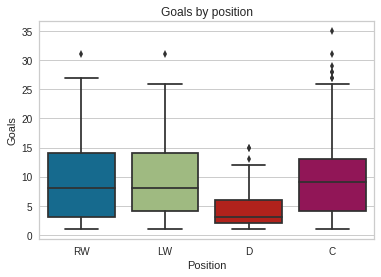

In [10]:
# Goals by position 
ax = sns.boxplot(x = "Pos", y = "G", data = df)
ax.set_title("Goals by position")
plt.xlabel("Position")
plt.ylabel("Goals")
plt.show()

More or less equal for forwards. Considerably lower for defensemen.<br> 

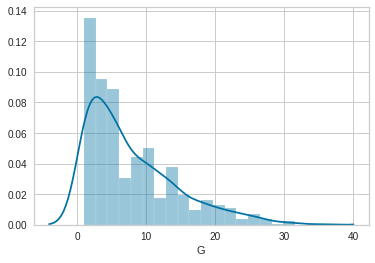

In [11]:
# goal distribution plot
ax = sns.distplot(df['G'])

##### Majority of the players with 10 goals or less. 

#### Goals by Games played regression plot

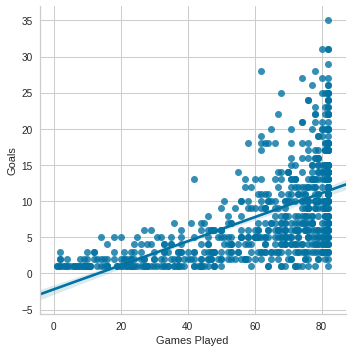

In [12]:
# regression plot ... goals by games played
ax = sns.lmplot(x = "GP", y = "G", data = df)
plt.xlabel("Games Played")
plt.ylabel("Goals")
plt.show()

#### All of the 10 + goals scorers have played at least 40 games.

In [13]:
# one hot encoding the Pos feature.
df = pd.get_dummies(df)

#### Plot the correlation matrix

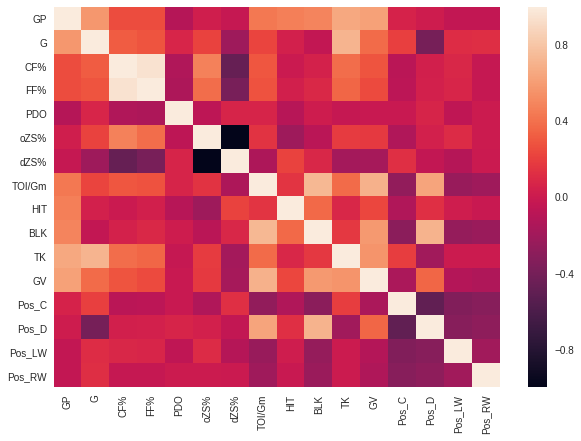

In [14]:
# correlation matrix
corr = df.corr() 
# plot the heatmap
plt.figure(figsize=(10,7))
ax = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
 

##### High correlation between Corsi CF% and Fenwick FF%. 

### Build the xgboost model

In [15]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

X =  df.drop(['G'], axis=1)
# target column: we are predicting goals
y = df.G
# split training and test
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state=123)
 

In [16]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline 

my_pipeline = Pipeline([('xgb', XGBRegressor())])

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

param_grid = {
    "xgb__n_estimators": [10, 50, 100, 500],
    "xgb__learning_rate": [0.1, 0.5, 1],
}
fit_params = {"xgb__eval_set": [(val_X, val_y)], 
              "xgb__early_stopping_rounds": 10, 
              "xgb__verbose": False} 

searchCV = GridSearchCV(my_pipeline, cv=10, param_grid=param_grid, fit_params=fit_params)
searchCV.fit(train_X, train_y)  
 
best_parameters=searchCV.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
preds = searchCV.predict(val_X)

	xgb__learning_rate: 0.1
	xgb__n_estimators: 50


#### Predicted values

In [18]:
from sklearn.metrics import mean_squared_error
searchCV.fit(train_X,train_y)
preds = searchCV.predict(val_X)
preds

array([ 5.0013914, 19.80898  ,  3.5766275,  2.430603 ,  5.50814  ,
        5.891071 ,  4.860912 , 17.034973 ,  1.4251184, 10.121978 ,
       13.608052 ,  8.539052 , 12.737987 ,  4.4114256,  1.928529 ,
        8.300209 , 10.167964 , 20.188217 ,  3.4991944,  7.410309 ,
        2.9765573,  5.5072207,  8.19539  ,  7.3605156, 19.569517 ,
       14.13485  , 10.894954 ,  0.7384128,  2.0144422,  6.3580556,
        4.5007505,  3.6201959,  3.8745823,  7.886003 ,  5.659622 ,
        6.6688824,  5.772203 ,  1.7850425, 10.427955 ,  5.0377254,
       16.02443  ,  1.6519076,  3.0261183, 16.655697 , 19.103523 ,
        7.130028 , 14.516799 ,  5.2131286, 17.28891  ,  2.4957309,
        3.2240481,  3.245179 ,  1.747113 ,  5.0879717,  2.1930008,
       17.597757 ,  7.9616795,  8.540046 ,  2.0743504,  2.012041 ,
        3.8018749,  3.333365 ,  5.8969836,  9.347158 ,  4.9013624,
        4.786928 ,  5.361251 ,  4.586094 , 13.351409 ,  4.621348 ,
        9.27827  ,  2.24116  , 18.326017 , 16.019146 ,  3.0404

#### Difference between predicted values and the actual values.

In [19]:
rmse = np.sqrt(mean_squared_error(val_y, preds))
print("RMSE: %f" % (rmse))

RMSE: 3.719920


#### Predictions are off by 3.71 goals. <br>Want to believe that 3.71 goals over the course of a season is good. However I may lack domain knowledge.  

#### Feature importance plot

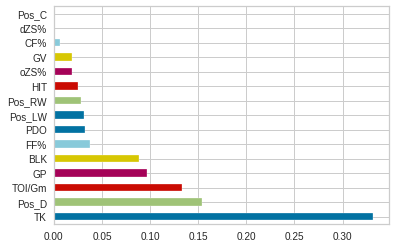

In [20]:
importance = searchCV.best_estimator_.named_steps["xgb"].feature_importances_ 
feat_importances = pd.Series(importance, index=train_X.columns)
ax = feat_importances.nlargest(20).plot(kind='barh')


#### Was expecting Games Played and Time on Ice per game to be the most important features.<br> Really surprised to how Takeways rates. 